#VAE model that can classify anomalies in computer network data.
Dataset can be downloaded from
https://drive.google.com/drive/folders/18pFPl_Daa2wwmBNeQK-QQ1e4NL6zJPFq?usp=sharing

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as kr
from keras import metrics, optimizers, regularizers
from scipy.stats import norm
from numpy.random import seed
seed(1)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Fetch the data directly from the location you saved
data = pd.read_csv('network_attack_data.csv') #load the dataset using pandas
data.head() # display the first 5 rows


,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,Label
0,109998919,4,3,525,0.0,520,0,131.25,259.177385,0,...,32,5735.0,0.0,5735.0,5735.0,110000000.0,0.0,110000000.0,110000000.0,1
1,109993343,4,3,531,0.0,520,0,132.75,258.218738,0,...,32,5437.0,0.0,5437.0,5437.0,110000000.0,0.0,110000000.0,110000000.0,1
2,109988359,4,3,535,0.0,520,0,133.75,257.597069,0,...,32,5505.0,0.0,5505.0,5505.0,110000000.0,0.0,110000000.0,110000000.0,1
3,109982960,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5303.0,0.0,5303.0,5303.0,110000000.0,0.0,110000000.0,110000000.0,1
4,109977744,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5356.0,0.0,5356.0,5356.0,110000000.0,0.0,110000000.0,110000000.0,1


In [ ]:
data['Label'].value_counts() #count the number of classes (Benign and Attack)

Label
0    22987
1     5498
Name: count, dtype: int64

In [ ]:
benign = data['Label']== 0 # create a dataframe for benign data
attack= data['Label']!= 0  # create dataframe for attack data

data_benign = data[benign]
data_attack = data[attack]

print(f"Benign count: {len(data_benign)}")
print(f"Attack count: {len(data_attack)}")

Benign count: 22987
Attack count: 5498


In [ ]:
# convert dataframes to numpy arrays after dropping the label (Label 0/1)
x_benign = data_benign.drop('Label',axis=1).values
y_benign = data_benign['Label'].values

x_attack = data_attack.drop('Label',axis=1).values
y_attack = data_attack['Label'].values

print(x_benign.shape, x_attack.shape)
print(y_benign.shape, y_attack.shape)

(22987, 76) (5498, 76)
(22987,) (5498,)


In [ ]:
#train-test split for benign train and test data
from sklearn.model_selection import train_test_split
x_benign_train, x_benign_test = train_test_split(x_benign, test_size=0.25, random_state=40)
print(x_benign_train.shape, x_benign_test.shape)

(17240, 76) (5747, 76)


#Data Scaling using Min-Max Scalar

In [ ]:
import joblib
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler=MinMaxScaler()
x_benign_tr_scaled= scaler.fit_transform(x_benign_train) # fit_transform on train data
x_benign_tst_scaled= scaler.transform(x_benign_test) # transform on test data
x_attack_scaled= scaler.transform(x_attack) # transform on test data

#Define the sampling layer


In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z

#Set hyperparameters

In [ ]:
# data features
num_features = 76

# Training parameters.
batch_size = 64
epochs = 50

# Neural Network Parameters
hidden_1 = 100 # 1st layer number of neurons
hidden_2 = 100 # 2nd layer number of neurons
latent_dim = 5

#Define the encoder

In [ ]:
inputs = kr.layers.Input(shape=(num_features, ), name='input') #num_features = 76 # number of input features
x1 = kr.layers.Dense(hidden_1, activation='relu')(inputs) ## First hidden layer
x2 = kr.layers.Dense(hidden_2, activation='relu')(x1) ##Second hidden layer
z_mean = kr.layers.Dense(latent_dim, name='z_mean')(x2) ### Latent layer
z_log_var = kr.layers.Dense(latent_dim, name='z_log_var')(x2) #latent_dim = 2

#Define the sampling/latent layer


In [ ]:
z = kr.layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = kr.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 76)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 100)                  7700      ['input[0][0]']               
                                                                                                  
 dense_1 (Dense)             (None, 100)                  10100     ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 5)                    505       ['dense_1[0][0]']             
                                                                                            

#Define the encoder


In [ ]:
latent_inputs = kr.layers.Input(shape=(latent_dim,), name='z_sampling')
x1 = kr.layers.Dense(hidden_2, activation='relu')(latent_inputs) ## First hidden layer
x2 = kr.layers.Dense(hidden_1, activation='relu')(x1) ## Second hidden layer
outputs = kr.layers.Dense(num_features, activation='sigmoid')(x2) #num_features = 76 # number of input features

# instantiate decoder model
decoder = kr.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 5)]               0         
                                                                 
 dense_2 (Dense)             (None, 100)               600       
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 76)                7676      
                                                                 
Total params: 18376 (71.78 KB)
Trainable params: 18376 (71.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#Instantiate the VAE model

In [ ]:
# # VAE model = encoder + decoder
outputs = decoder(encoder(inputs)[2])  # Select the z value from outputs of the encoder
vae = kr.Model(inputs, outputs, name='vae')

#Compute VAE Loss

In [ ]:
# Reconstruction loss
reconstruction_loss = tf.losses.mean_squared_error(inputs, outputs)
reconstruction_loss = reconstruction_loss * num_features

# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
adam = optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=adam) ##compile the model
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 76)]                 0         []                            
                                                                                                  
 encoder (Functional)        [(None, 5),                  18810     ['input[0][0]']               
                              (None, 5),                                                          
                              (None, 5)]                                                          
                                                                                                  
 decoder (Functional)        (None, 76)                   18376     ['encoder[0][2]']             
                                                                                                

#Train the VAE Model

In [ ]:
history= vae.fit(x_benign_tr_scaled ,x_benign_tr_scaled, verbose = 1, batch_size=batch_size, epochs=epochs,shuffle=True,validation_split=0.2) #unsupervised learning because only x values used (no y values or labels)

Epoch 1/50
216/216 [==============================] - 8s 6ms/step - loss: 3.1710 - val_loss: 1.4643
Epoch 2/50
216/216 [==============================] - 1s 5ms/step - loss: 1.4381 - val_loss: 1.4455
Epoch 3/50
216/216 [==============================] - 1s 5ms/step - loss: 1.4240 - val_loss: 1.4425
Epoch 4/50
216/216 [==============================] - 1s 5ms/step - loss: 1.4232 - val_loss: 1.4365
Epoch 5/50
216/216 [==============================] - 1s 6ms/step - loss: 1.4176 - val_loss: 1.4273
Epoch 6/50
216/216 [==============================] - 1s 6ms/step - loss: 1.4119 - val_loss: 1.4263
Epoch 7/50
216/216 [==============================] - 2s 8ms/step - loss: 1.4082 - val_loss: 1.4261
Epoch 8/50
216/216 [==============================] - 1s 5ms/step - loss: 1.4084 - val_loss: 1.4229
Epoch 9/50
216/216 [==============================] - 1s 5ms/step - loss: 1.4050 - val_loss: 1.4189
Epoch 10/50
216/216 [==============================] - 1s 5ms/step - loss: 1.4050 - val_loss: 1.4220

In [ ]:
#save the model
encoder.save('encoder_model.h5')
decoder.save('decoder_model.h5')
vae.save('vae_model.h5')

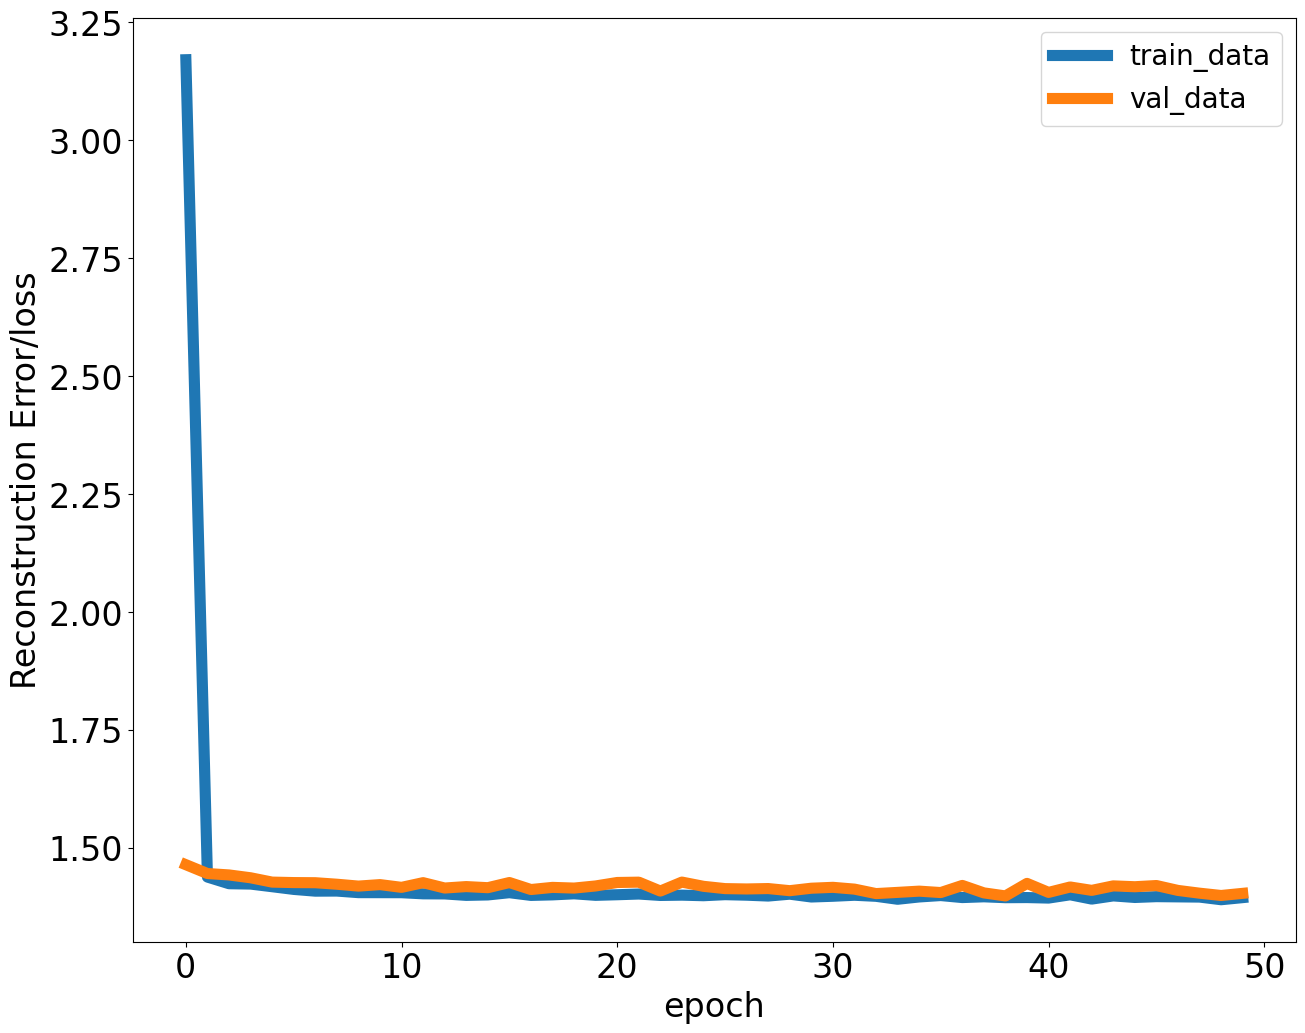

In [ ]:
# loss plot train-validation
import matplotlib as mpl

mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (15,12)
plt.plot(history.history['loss'],linewidth = 8)
plt.plot(history.history['val_loss'],linewidth = 8)
#plt.title('model loss',fontsize = 24)
plt.ylabel('Reconstruction Error/loss',fontsize = 24)
plt.xlabel('epoch',fontsize = 24)
plt.legend(['train_data', 'val_data'], loc='best',fontsize = 20)
plt.show()

#Make the predictions on different datasets (train/test)

In [ ]:
from sklearn import metrics

pred1 = vae.predict(x_benign_tr_scaled) # predictions on train benign data
score1 = np.sqrt(metrics.mean_squared_error(pred1,x_benign_tr_scaled))

pred2 = vae.predict(x_benign_tst_scaled) # predictions on test benign data
score2 = np.sqrt(metrics.mean_squared_error(pred2,x_benign_tst_scaled))

pred3 = vae.predict(x_attack_scaled) # predictions on test attack data
score3 = np.sqrt(metrics.mean_squared_error(pred3,x_attack_scaled))

print(f"Benign_training_data Score (RMSE): {score1}")
print(f"Benign_test_data_score Score (RMSE): {score2}")
print(f"Attack_test_data_score (RMSE): {score3}")

172/172 [==============================] - 1s 3ms/step
Benign_training_data Score (RMSE): 0.13117769412166927
Benign_test_data_score Score (RMSE): 0.1323020346479927
Attack_test_data_score (RMSE): 0.22163826965477795


#Combine the test data (benign) and attack data

In [ ]:
tst_obs = x_benign_tst_scaled.copy() # create a copy of benign data and save in tst_obs
print(tst_obs.shape)
tst_obs = np.append(tst_obs, x_attack_scaled, axis=0) ##combine test benign and test attack data
print(tst_obs.shape)
print(y_benign[0:5747].shape)


(5747, 76)
(11245, 76)
(5747,)


In [ ]:
Y_obs = y_benign[0:5747].copy() # create a copy of benign labels and save in Y_obs
Y_obs  = np.append(Y_obs, y_attack, axis=0)
print(Y_obs.shape)

(11245,)


#Make predictions using the VAE model

In [ ]:
test_preds=vae.predict(tst_obs) # TEST BENIGN +TEST ATTACK
mse_test = np.mean(np.power(tst_obs- test_preds, 2), axis=1)
mse_test.shape

352/352 [==============================] - 1s 2ms/step


(11245,)

In [ ]:
tst_error_data = pd.DataFrame({'recon_error': mse_test,'Class': Y_obs})

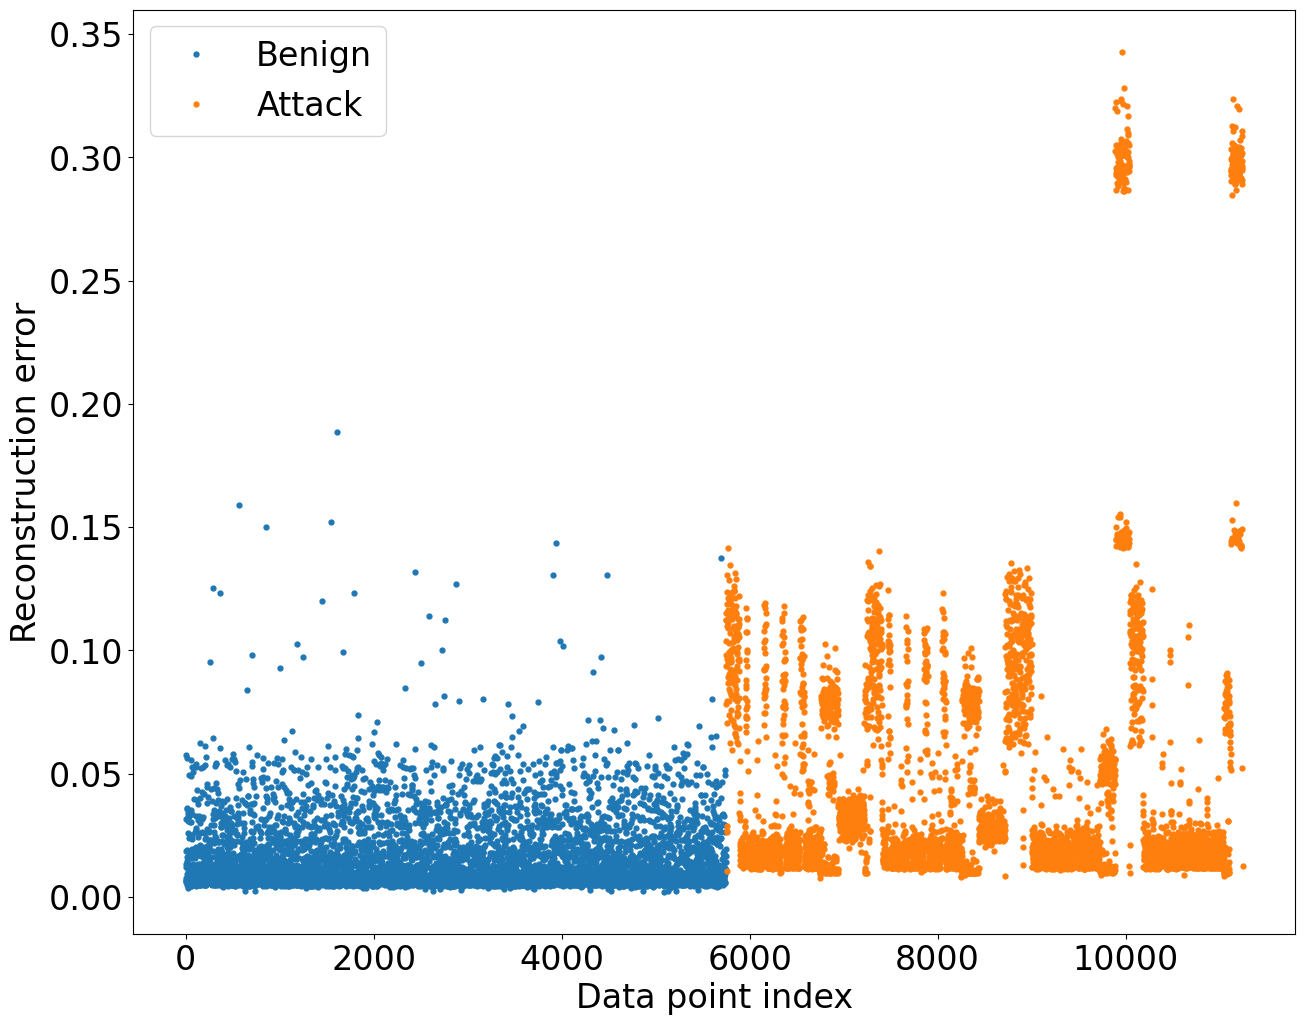

In [ ]:
#####RE for different classes of data

group1 = tst_error_data.groupby('Class')
fig, ax = plt.subplots()
for name, group in group1:
    ax.plot(group.index, group.recon_error, marker='o', ms=3.5, linestyle='',label= "Attack" if name == 1 else "Benign")
ax.legend()
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

# How well does the unsupervised classifier work (Metric analysis)?

In [ ]:
# Compute confusion matrix for test data (benign+attack)
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)

threshold=0.05 ##selected using trial and error based on improving the TPR and TNR values

y_pred = [1 if e > threshold else 0 for e in tst_error_data.recon_error.values]

cm= confusion_matrix(tst_error_data.Class, y_pred)
print("Confusion matrix:")
print(cm)

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives", tp)
print("Total number of false negatives",fn)
print("Total number of false positives",fp)
print("Total number of true negatives",tn)

acc=float(tp+tn)/(tp+tn+fp+fn)

print('\nClassifier Accuracy: %.2f%%' % (acc * 100))

tpr = float(tp)/(tp+fn)

print('True Positive Rate (TPR/Recall/Sensitivity): %.2f%%' % (tpr * 100))

specificity = float (tn)/(tn+fp)

print ("True Negative Rate (TNR/Specificity/selectivity):%.2f%%" % (specificity*100))

fpr = float(fp)/(fp+tn)
print("False Positive Rate (FPR): %.2f%%" % (fpr * 100))

fnr = fn/ (fn+ tp)
print("False Negative Rate (FNR): %.2f%%" % (fnr*100))

precision=float(tp)/(tp+fp)
print("Precision/Positive Predictive value:%.2f%%" %(precision*100))

fscore = 2*((precision*tpr)/(precision+tpr))
print("F1-Score: %.2f%%" %(fscore*100))


Confusion matrix:
[[5492  255]
 [3862 1636]]

Total number of true positives 1636
Total number of false negatives 3862
Total number of false positives 255
Total number of true negatives 5492

Classifier Accuracy: 63.39%
True Positive Rate (TPR/Recall/Sensitivity): 29.76%
True Negative Rate (TNR/Specificity/selectivity):95.56%
False Positive Rate (FPR): 4.44%
False Negative Rate (FNR): 70.24%
Precision/Positive Predictive value:86.52%
F1-Score: 44.28%


Text(0.5, 0, 'False Positive Rate')

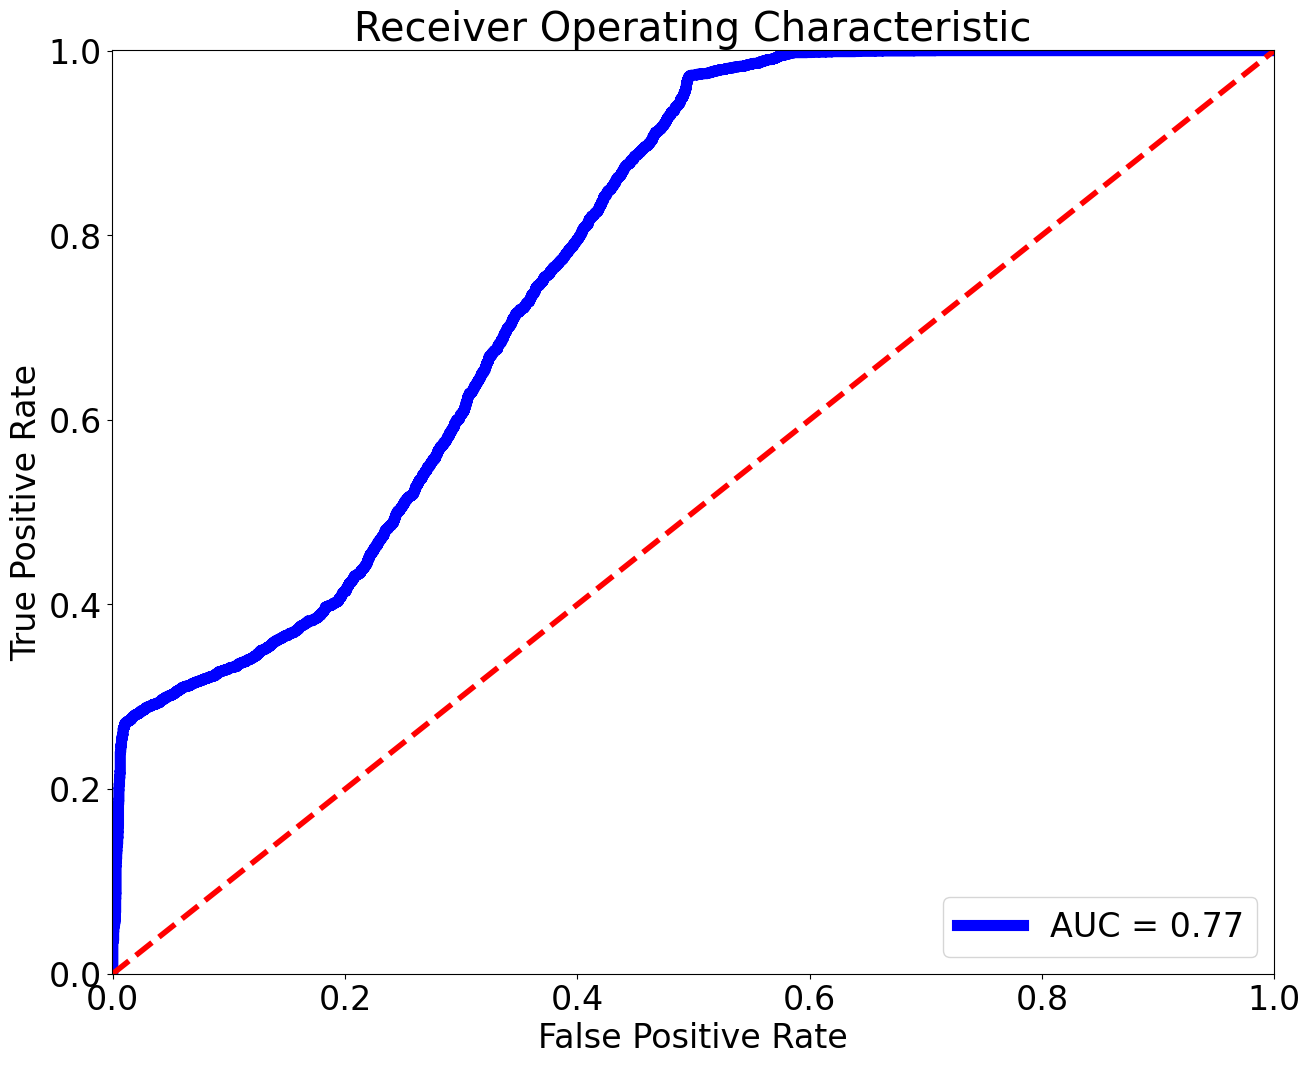

In [ ]:
##########ROC GRAPH#######

fpr, tpr, thresholds = roc_curve(tst_error_data.Class,tst_error_data.recon_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc,linewidth = 8, color='b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--',linewidth = 4)
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')